In [1]:
import os
import cv2
import csv
import sys
import copy
from tqdm import tqdm
import random
import librosa
import librosa.display
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import label_ranking_average_precision_score, accuracy_score
import torchvision
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd 
import skimage.io
from skimage.transform import resize
import albumentations as albu
from albumentations import pytorch as AT
from PIL import Image


import pretrainedmodels
from resnest.torch import resnest50
import timm

sys.path.append('../')

import src.audio_augs as aa
from src.utils import patch_first_conv
from src.loss import lsep_loss_stable, lsep_loss
from src.batch_mixer import BatchMixer
from src.pann import *

import warnings
warnings.filterwarnings('ignore')


/home/user/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
train_folder_path = "../data/train/"
train_np_folder_path = "../data/train_np/"
test_folder_path = "../data/test/"
sample_submission = "../data/sample_submission.csv"
train_tp_path = "../data/train_tp.csv"
train_fp_path = "../data/train_fp.csv"
train_tp_folds = pd.read_csv("../data/train_tp_folds_v3.csv")
train_fp_folds = pd.read_csv("train_fp_folds.csv").drop("Unnamed: 0", 1)

train_files = os.listdir(train_folder_path)
test_files = os.listdir(test_folder_path)

train_tp = pd.read_csv(train_tp_path)
train_fp = pd.read_csv(train_fp_path)

_df = pd.read_csv("missing_3classes_extended.csv")
_df = _df.drop(columns="Unnamed: 0")

pseudo = pd.read_csv("pseudolabels_raw.csv")
pseudo_clear = pseudo[pseudo.mean_confidence > 0.99]

In [3]:
pseudo_clear = pseudo_clear.rename(columns={"offset": "t_max", "onset": "t_min", "file_id": "recording_id", "max_confidence":"f_min", "mean_confidence": "f_max"})
pseudo_clear["songtype_id"] =1 
pseudo_clear = pseudo_clear[['recording_id', 'species_id', 'songtype_id', 't_min', 'f_min', 't_max', "f_max"]]
pseudo_clear = pseudo_clear[~(pseudo_clear.species_id == 12)]

In [4]:
class Config:
    SEED = 17
    NUM_BIRDS = 24
    BATCH_SIZE = 16
    NUM_WORKERS = 8
    IMG_H = 200
    IMG_W = 600
    FOLD = 0
    TEST_FOLD = 5
    
    #optimizer params
    LR = 0.01
    LR_ADAM = 9e-4
    WEIGHT_DECAY = 0.0001
    MOMENTUM = 0.9
    T_MAX = 8
    
    #scheduler params
    FACTOR = 0.7
    PATIENCE = 2
    
    #spec params
    FFT = 2048
    HOP = 512
    MEL = 224
    SR = 48000
    Fmin = 84 
    Fmax = 15056
    LENGTH_1  = 10 * SR
    LENGTH_2 = 5*SR
    STRIDE = 5
    #TODO: MAKE AUGS CONF

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(Config.SEED)

def wav2mel(wav, power):
    mel_spec = librosa.feature.melspectrogram(wav, n_fft=Config.FFT, 
                                                  hop_length=Config.HOP, 
                                                  sr=Config.SR, 
                                                  fmin=Config.Fmin, 
                                                  fmax=Config.Fmax, 
                                                  power=power, n_mels=Config.MEL)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec

pcen_parameters = {   
      "gain": 0.98,
      "bias": 2,
      "power": 0.5,
      "time_constant": 0.4,
      "eps": 0.000001 }

def normalize_melspec(X: np.ndarray):
    eps = 1e-6
    mean = X.mean()
    X = X - mean
    std = X.std()
    Xstd = X / (std + eps)
    norm_min, norm_max = Xstd.min(), Xstd.max()
    if (norm_max - norm_min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def crop_or_pad(y, is_train=True):
    length = Config.LENGTH_1
    if len(y) < length:
        y = np.pad(y, length, "minimum")
    elif len(y) > length:
        if not is_train:
            start = 0
        else:
            start = np.random.randint(len(y) - length)

        y = y[start:start + length]

    y = y.astype(np.float32, copy=False)

    return y

In [6]:
class RainforestDataset(Dataset):
    def __init__(self, df, audio_transforms = None, image_transforms = None,):
        self.audio_transforms = audio_transforms
        self.img_transforms = image_transforms
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sample = copy.deepcopy(self.df.iloc[idx, :].values)

        #bird_id = sample[1]
        #label_array = np.zeros(Config.NUM_BIRDS, dtype=np.single)
        #if sample[-1]:
        #    label_array[bird_id] = 1.
        try:
            wav = np.load(train_np_folder_path + sample[0] + ".npy")
        except:
            wav, sr = librosa.load('../data/test/' + sample[0] + ".flac", sr=None)
        tmin = float(sample[3]) * Config.SR
        tmax = float(sample[5]) * Config.SR
        center = np.round((tmin + tmax) / 2)   
        beginning = center - Config.LENGTH_1 / 2
        if beginning < 0:
            beginning = 0
            
        beginning = np.random.randint( beginning , center)
        ending = beginning + Config.LENGTH_1
        if ending > len(wav):
            ending = len(wav)
            beginning = ending - Config.LENGTH_1 
            
        wav_slice = wav[int(beginning):int(ending)]
        
        beginning_time = beginning / Config.SR
        ending_time = ending / Config.SR
        recording_id = sample[0]
        query_string = f"recording_id == '{recording_id}' & "
        query_string += f"t_min < {ending_time} & t_max > {beginning_time}"
        all_tp_events = self.df.query(query_string)

        label_array = np.zeros(24, dtype=np.float32)
        for species_id in all_tp_events["species_id"].unique():
            label_array[int(species_id)] = 1.0
            if species_id == 12:
                    label_array[3] = 0.99
        
        if self.audio_transforms: # and bird_id not in (3, 7, 8, 9):
            wav_slice =  self.audio_transforms(wav_slice)

        mel_spec = wav2mel(wav_slice, power=1)
        mel_spec_power =  wav2mel(wav_slice, power=1.5)
        pcen = librosa.pcen(mel_spec, **pcen_parameters)
        #mel_spec = np.expand_dims(mel_spec, axis=2).astype(np.float32)
        #print(np.max(mel_spec))
        image = np.stack([normalize_melspec(mel_spec), normalize_melspec(pcen), normalize_melspec(mel_spec_power)], axis=-1).astype(np.float32)
        
        
        if self.img_transforms:
            image =  self.img_transforms(image=image)
            mel_spec = image["image"]
        
        return mel_spec, label_array

In [7]:
X_train = train_tp_folds[(train_tp_folds['fold'] != Config.FOLD)].reset_index(drop=True)
X_val = train_tp_folds[train_tp_folds['fold'] == Config.FOLD].reset_index(drop=True)


_df = _df[(_df.recording_id.isin(X_train.recording_id)) ]
X_train = X_train[_df.columns]
X_train = pd.concat([X_train, _df])

add_pseudo = False
if add_pseudo:
    X_train = X_train[pseudo_clear.columns]
    X_train = pd.concat([X_train, pseudo_clear])

print('Training on ' + str(len(X_train)) + ' examples')
print('Validating on ' + str(len(X_val)) + ' examples')

Training on 1155 examples
Validating on 218 examples


In [8]:
audio_transform_train = aa.Compose([
  aa.OneOf([
    aa.GaussianNoiseSNR(min_snr=5.0, max_snr=20.0),
    aa.PinkNoiseSNR( min_snr=5.0, max_snr=20.0,)
  ]),
  #aa.PitchShift(max_steps=1.2, sr=Config.SR, p=0.3),
  #aa.TimeStretch(max_rate=1.2, p=0.3),
  aa.TimeShift(sr=Config.SR),
  aa.VolumeControl(mode="sine", p=0.5),  

])

image_transform_train = albu.Compose([albu.Resize(Config.IMG_H, Config.IMG_W), AT.ToTensorV2()])
transform_val = albu.Compose([albu.Resize(Config.IMG_H, Config.IMG_W), AT.ToTensorV2()])

In [9]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss

class PANNsLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input_ = input["clipwise_output"]
        input_ = torch.where(torch.isnan(input_),
                             torch.zeros_like(input_),
                             input_)
        input_ = torch.where(torch.isinf(input_),
                             torch.zeros_like(input_),
                             input_)

        target = target.float()

        return self.bce(input_, target)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
            ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size()) == 2:
            loss = loss.sum(dim=1)
        return loss.mean()    

class ImprovedPANNsLoss(nn.Module):
    def __init__(self, output_key="logit", weights=[1, 0.5]):
        super().__init__()

        self.output_key = output_key
        if output_key == "logit":
            self.normal_loss = nn.BCEWithLogitsLoss()
        else:
            self.normal_loss = nn.BCELoss()

        self.bce = nn.BCELoss()
        self.weights = weights

    def forward(self, input, target):
        input_ = input[self.output_key]
        target = target.float()

        framewise_output = input["framewise_output"]
        clipwise_output_with_max, _ = framewise_output.max(dim=1)

        normal_loss = self.normal_loss(input_, target)
        auxiliary_loss = self.bce(clipwise_output_with_max, target)

        return self.weights[0] * normal_loss + self.weights[1] * auxiliary_loss
    
class ImprovedFocalLoss(nn.Module):
    def __init__(self, weights=[1, 1]):
        super().__init__()

        self.focal = FocalLoss()
        self.weights = weights

    def forward(self, input, target):
        input_ = input["logit"]
        target = target.float()

        framewise_output = input["framewise_logit"]
        clipwise_output_with_max, _ = framewise_output.max(dim=1)

        normal_loss = self.focal(input_, target)
        auxiliary_loss = self.focal(clipwise_output_with_max, target)

        return self.weights[0] * normal_loss + self.weights[1] * auxiliary_loss

In [10]:
train_dataset = RainforestDataset(X_train, audio_transforms=audio_transform_train, image_transforms=image_transform_train)
val_dataset = RainforestDataset(X_val, audio_transforms=None, image_transforms=transform_val)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers = Config.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle = False, num_workers = Config.NUM_WORKERS)

class AudioSEDModel(nn.Module):
    def __init__(self, classes_num):
        super().__init__()
        self.interpolate_ratio = 30  # Downsampled ratio     
        # Model Encoder
        
        self.encoder = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)
        in_features = self.encoder.classifier.in_features
        
        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlock(in_features, classes_num, activation="sigmoid")
        self.init_weight()
    
    def init_weight(self):
        init_layer(self.fc1)
    
    def forward(self, input, mixup_lambda=None):
        frames_num = input.size(3)

        #print(x.shape)
        x = self.encoder.forward_features(input)
        #print(x.shape)
        x = torch.mean(x, dim=2)
        #print(x.shape)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2
        #print(x.shape)

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        #print(x.shape)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)
        
        framewise_logit = interpolate(segmentwise_logit, self.interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            "framewise_output": framewise_output,
            "segmentwise_output": segmentwise_output,
            "logit": logit,
            "framewise_logit": framewise_logit,
            "clipwise_output": clipwise_output
        }


        return output_dict
model = AudioSEDModel(Config.NUM_BIRDS)

optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR_ADAM, )
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = Config.FACTOR)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = Config.PATIENCE, factor = Config.FACTOR, mode = "max")
scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8, eta_min=1e-6)
#scheduler =torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, eta_min=1e-4)
criterion = ImprovedPANNsLoss()
criterion_focal = ImprovedFocalLoss()

mixer = BatchMixer(p=0.45)

if torch.cuda.is_available():
    model = model.cuda()
    #loss_function = loss_function.cuda()

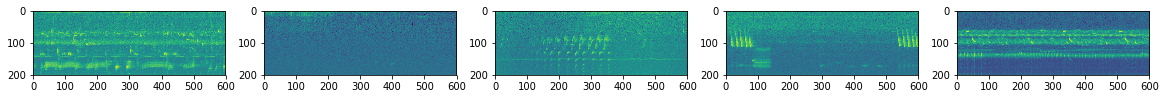

In [11]:
plt.figure(figsize = (20,10))
columns = 5
images = ([train_dataset[i][0] for i in range(5)])
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1) 
    plt.imshow(image.numpy().transpose(1,2,0)[:,:,2])

In [12]:
def load_val_file(record_id, df):

    wav = np.load('../data/train_np/' + record_id + ".npy")
    # Split for enough segments to not miss anything
    #segments = len(wav) / Config.LENGTH_1
    #segments = int(np.ceil(segments))
    window = 10* Config.SR
    stride = 5 * Config.SR
    full_length = 60 * Config.SR
    
    mel_array = []
    
    for i in range(0, full_length + stride - window, stride):
        
        wav_slice = wav[i:i+window]
        mel_spec = wav2mel(wav_slice, power=1)
        mel_spec_power =  wav2mel(wav_slice, power=1.5)
        pcen = librosa.pcen(mel_spec, **pcen_parameters)
        #mel_spec = np.expand_dims(mel_spec, axis=2).astype(np.float32)
        #print(np.max(mel_spec))
        image = np.stack([normalize_melspec(mel_spec), normalize_melspec(pcen), normalize_melspec(mel_spec_power)], axis=-1).astype(np.float32)
        
        transform_val = albu.Compose([albu.Resize(Config.IMG_H, Config.IMG_W),],) 
        augmented = transform_val(image = image)
        mel_spec = augmented[ "image"] 
        #mfcc = augmented["image1"]
        #print(mel_spec.shape, mfcc.shape)
        mel_array.append(mel_spec) 
        
    val_labels_array = np.zeros(Config.NUM_BIRDS, dtype=np.single)
    species_ids = copy.deepcopy(df[(df.recording_id==record_id)].species_id.unique())
    val_labels_array[species_ids] = 1.
    if 12 in species_ids:
        val_labels_array[3] = 0.99
    #print(np.array(mel_array).shape)

    return np.array(mel_array), val_labels_array

def lwlrap(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
      truth[nonzero_weight_sample_indices, :] > 0,
      scores[nonzero_weight_sample_indices, :],
      sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap


def validate(model, files_ids, df):
        val_loss = []
        val_corr = []
        val_metrics = []
        model.eval()
        for i in tqdm(range(0, len(files_ids))):
            data, target = load_val_file(files_ids[i], X_val)
            data, target = torch.tensor(data.transpose(0,3,1,2)), torch.tensor(target)
            data = data.float()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda().unsqueeze(0)
            output = model(data)
            #output, _ = torch.max(output["clipwise_output"], 0)
            framewise_output = output["framewise_output"]
            output, _ = framewise_output.max(dim=1) 
            output, _ = torch.max(output, 0)
          
            output = output.unsqueeze(0)
            #print(output.shape)
            #loss = loss_function(output, target)
            loss = lsep_loss(output, target)
            val_metric = lwlrap(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            vals, answers = torch.max(output, 1)
            vals, targets = torch.max(target, 1)
            val_metrics.append(val_metric.item())
            corrects = 0
            for i in range(0, len(answers)):
                if answers[i] == targets[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)
            val_loss.append(loss.item())
        valid_epoch_metric = sum(val_metrics) / len(val_loss)

        return val_loss, val_corr, valid_epoch_metric

In [13]:
best_corrects = 0
files_ids = copy.deepcopy(X_val.recording_id.unique())
# Train loop
print('Starting training loop')
for e in range(0, 100):
    # Stats
    train_loss = []
    train_corr = []
    
    # Single epoch - train
    model.train()
    for batch, (data, target) in tqdm(enumerate(train_loader)):
        data = data.float()
        data, target = mixer(data, target)
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = model(data)
        #loss = loss_function(output, target)
        #label_smoothing_list = [0.005, 0.01, 0.075 ]
        #label_smoothing = random.choice(label_smoothing_list) 
        #targets_smooth = target * (1 - label_smoothing) + 0.5 * label_smoothing
        
        #loss = loss_function(output, targets_smooth)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        #scheduler.step()        
        # Stats
        vals, answers = torch.max(output["clipwise_output"], 1)
        vals, targets = torch.max(target, 1)
        corrects = 0
        for i in range(0, len(answers)):
            if answers[i] == targets[i]:
                corrects = corrects + 1
        train_corr.append(corrects)
        
        train_loss.append(loss.item())
    
    # Stats
    for g in optimizer.param_groups:
        lr = g['lr']
    print('Epoch ' + str(e) + ' training end. LR: ' + str(lr) + ', Loss: ' + str(sum(train_loss) / len(train_loss)) +
          ', Correct answers: ' + str(sum(train_corr)) + '/' + str(train_dataset.__len__()))
    
    with torch.no_grad():
                # Stats
        val_loss, val_corr, valid_epoch_metric = validate(model, files_ids, X_val)
    # Stats
    print('Epoch ' + str(e) + ' validation end. LR: ' + str(lr) + ', Loss: ' + str(sum(val_loss) / len(val_loss)) +
          ', Correct answers: ' + str(sum(val_corr)) + '/' + str(len(files_ids)) + ", Val metric: " + str(valid_epoch_metric))
    
    # If this epoch is better than previous on validation, save model
    # Validation loss is the more common metric, but in this case our loss is misaligned with competition metric, making accuracy a better metric
    if valid_epoch_metric > best_corrects:
        print('Saving new best model at epoch ' + str(e) + ' ' + str(sum(val_corr)) + '/' + str(len(files_ids)))
        torch.save(model.state_dict(), 'best_model.pt')
        best_corrects = valid_epoch_metric
        
    # Call every epoch
    #scheduler.step(valid_epoch_metric)
    scheduler.step()

# Free memory
#del model

Starting training loop


73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 0 training end. LR: 0.0009, Loss: 0.4515480019458353, Correct answers: 211/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 0 validation end. LR: 0.0009, Loss: 3.159205227333882, Correct answers: 38/197, Val metric: 0.34896739965876744
Saving new best model at epoch 0 38/197



73it [01:42,  1.40s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 1 training end. LR: 0.0008657838498638234, Loss: 0.3208313861938372, Correct answers: 277/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 1 validation end. LR: 0.0008657838498638234, Loss: 3.0504249993919723, Correct answers: 39/197, Val metric: 0.42338968003266864
Saving new best model at epoch 1 39/197



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 2 training end. LR: 0.0007683444981433531, Loss: 0.28984871261740386, Correct answers: 373/1155


100%|██████████| 197/197 [02:47<00:00,  1.18it/s]

Epoch 2 validation end. LR: 0.0007683444981433531, Loss: 2.9263469821910566, Correct answers: 65/197, Val metric: 0.57202153199014
Saving new best model at epoch 2 65/197



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 3 training end. LR: 0.0006225162028481079, Loss: 0.2692341906567142, Correct answers: 457/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 3 validation end. LR: 0.0006225162028481079, Loss: 2.80214647593232, Correct answers: 81/197, Val metric: 0.621151089830741
Saving new best model at epoch 3 81/197



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 4 training end. LR: 0.0004505, Loss: 0.24232784832177096, Correct answers: 513/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 4 validation end. LR: 0.0004505, Loss: 2.697652246746315, Correct answers: 114/197, Val metric: 0.7500324125958643
Saving new best model at epoch 4 114/197



73it [01:43,  1.42s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 5 training end. LR: 0.0002784837971518922, Loss: 0.21966613155521758, Correct answers: 580/1155


100%|██████████| 197/197 [02:47<00:00,  1.18it/s]

Epoch 5 validation end. LR: 0.0002784837971518922, Loss: 2.655232905131306, Correct answers: 111/197, Val metric: 0.7414873902183547



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 6 training end. LR: 0.0001326555018566469, Loss: 0.2099373207925117, Correct answers: 615/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 6 validation end. LR: 0.0001326555018566469, Loss: 2.629453638483425, Correct answers: 121/197, Val metric: 0.7753179561555197
Saving new best model at epoch 6 121/197



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 7 training end. LR: 3.5216150136176606e-05, Loss: 0.20808650777764517, Correct answers: 602/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 7 validation end. LR: 3.5216150136176606e-05, Loss: 2.6351839673095547, Correct answers: 120/197, Val metric: 0.77112239142696



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 8 training end. LR: 1e-06, Loss: 0.197857482384329, Correct answers: 634/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 8 validation end. LR: 1e-06, Loss: 2.628784163954294, Correct answers: 123/197, Val metric: 0.7809335097472954
Saving new best model at epoch 8 123/197



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 9 training end. LR: 3.5216150136176606e-05, Loss: 0.19735797443618514, Correct answers: 609/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 9 validation end. LR: 3.5216150136176606e-05, Loss: 2.612677830729993, Correct answers: 124/197, Val metric: 0.7872733865119651
Saving new best model at epoch 9 124/197



73it [01:46,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 10 training end. LR: 0.000132655501856647, Loss: 0.20177338160064123, Correct answers: 622/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 10 validation end. LR: 0.000132655501856647, Loss: 2.602595761342702, Correct answers: 129/197, Val metric: 0.7972195152011968
Saving new best model at epoch 10 129/197



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 11 training end. LR: 0.00027848379715189234, Loss: 0.19561313664259977, Correct answers: 628/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 11 validation end. LR: 0.00027848379715189234, Loss: 2.6092317866794956, Correct answers: 123/197, Val metric: 0.7888788171783095



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 12 training end. LR: 0.00045050000000000054, Loss: 0.2048823063912457, Correct answers: 618/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 12 validation end. LR: 0.00045050000000000054, Loss: 2.626719017319268, Correct answers: 120/197, Val metric: 0.7627429113469724



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 13 training end. LR: 0.0006225162028481088, Loss: 0.2132577435815171, Correct answers: 596/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 13 validation end. LR: 0.0006225162028481088, Loss: 2.6724356527861, Correct answers: 113/197, Val metric: 0.7412366046249294



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 14 training end. LR: 0.0007683444981433541, Loss: 0.2126448103418089, Correct answers: 606/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 14 validation end. LR: 0.0007683444981433541, Loss: 2.637939886393281, Correct answers: 108/197, Val metric: 0.7361231971638061



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 15 training end. LR: 0.0008657838498638243, Loss: 0.2179115672838198, Correct answers: 621/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 15 validation end. LR: 0.0008657838498638243, Loss: 2.6395879203292925, Correct answers: 113/197, Val metric: 0.7502219438767663



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 16 training end. LR: 0.0009000000000000011, Loss: 0.20098024953718055, Correct answers: 629/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 16 validation end. LR: 0.0009000000000000011, Loss: 2.604390376715491, Correct answers: 118/197, Val metric: 0.7641690655650049



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 17 training end. LR: 0.0008657838498638245, Loss: 0.19354873283268653, Correct answers: 671/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 17 validation end. LR: 0.0008657838498638245, Loss: 2.612836561832331, Correct answers: 117/197, Val metric: 0.7642791122553346



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 18 training end. LR: 0.0007683444981433542, Loss: 0.18238101379103858, Correct answers: 667/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 18 validation end. LR: 0.0007683444981433542, Loss: 2.5782429978327097, Correct answers: 123/197, Val metric: 0.7911439448875995



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 19 training end. LR: 0.000622516202848109, Loss: 0.17491685364344348, Correct answers: 698/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 19 validation end. LR: 0.000622516202848109, Loss: 2.5739404658980782, Correct answers: 120/197, Val metric: 0.779776371400737



73it [01:46,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 20 training end. LR: 0.00045050000000000076, Loss: 0.16131854322675157, Correct answers: 706/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 20 validation end. LR: 0.00045050000000000076, Loss: 2.5372630859994647, Correct answers: 121/197, Val metric: 0.7926976999312026



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 21 training end. LR: 0.00027848379715189256, Loss: 0.15547600521208488, Correct answers: 726/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 21 validation end. LR: 0.00027848379715189256, Loss: 2.525133799780444, Correct answers: 130/197, Val metric: 0.8117677866408833
Saving new best model at epoch 21 130/197



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 22 training end. LR: 0.00013265550185664746, Loss: 0.14213228235914283, Correct answers: 742/1155


100%|██████████| 197/197 [02:44<00:00,  1.20it/s]

Epoch 22 validation end. LR: 0.00013265550185664746, Loss: 2.531274719286691, Correct answers: 121/197, Val metric: 0.790357527413365



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 23 training end. LR: 3.5216150136176816e-05, Loss: 0.1364843809135156, Correct answers: 754/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 23 validation end. LR: 3.5216150136176816e-05, Loss: 2.5186576286548283, Correct answers: 126/197, Val metric: 0.8018206553739552



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 24 training end. LR: 1e-06, Loss: 0.13421762642795093, Correct answers: 791/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 24 validation end. LR: 1e-06, Loss: 2.515406480295404, Correct answers: 132/197, Val metric: 0.8155364939628901
Saving new best model at epoch 24 132/197



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 25 training end. LR: 3.5216150136176606e-05, Loss: 0.13617165524461497, Correct answers: 747/1155


100%|██████████| 197/197 [02:44<00:00,  1.19it/s]

Epoch 25 validation end. LR: 3.5216150136176606e-05, Loss: 2.5167846909634353, Correct answers: 129/197, Val metric: 0.8085144973469848



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 26 training end. LR: 0.00013265550185664706, Loss: 0.14091878751777623, Correct answers: 756/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 26 validation end. LR: 0.00013265550185664706, Loss: 2.5115226513238125, Correct answers: 129/197, Val metric: 0.8170111191684797
Saving new best model at epoch 26 129/197



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 27 training end. LR: 0.0002784837971518918, Loss: 0.148436490293235, Correct answers: 732/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 27 validation end. LR: 0.0002784837971518918, Loss: 2.5317103378663814, Correct answers: 124/197, Val metric: 0.796152662903932



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 28 training end. LR: 0.00045049999999999973, Loss: 0.150787638321723, Correct answers: 724/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 28 validation end. LR: 0.00045049999999999973, Loss: 2.550189527763328, Correct answers: 118/197, Val metric: 0.7720491719222686



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 29 training end. LR: 0.0006225162028481078, Loss: 0.16021961300340418, Correct answers: 726/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 29 validation end. LR: 0.0006225162028481078, Loss: 2.563062120815219, Correct answers: 107/197, Val metric: 0.7467287084038353



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 30 training end. LR: 0.0007683444981433525, Loss: 0.1615957961711165, Correct answers: 709/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 30 validation end. LR: 0.0007683444981433525, Loss: 2.5471726879855705, Correct answers: 131/197, Val metric: 0.8056454588247267



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 31 training end. LR: 0.0008657838498638232, Loss: 0.17902658634806332, Correct answers: 697/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 31 validation end. LR: 0.0008657838498638232, Loss: 2.598799037449251, Correct answers: 99/197, Val metric: 0.7171754194210602



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 32 training end. LR: 0.0008999999999999999, Loss: 0.18441583359078184, Correct answers: 681/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 32 validation end. LR: 0.0008999999999999999, Loss: 2.6033108185995655, Correct answers: 117/197, Val metric: 0.757005571980191



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 33 training end. LR: 0.0008657838498638233, Loss: 0.1623670298555126, Correct answers: 737/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 33 validation end. LR: 0.0008657838498638233, Loss: 2.5661893108774563, Correct answers: 114/197, Val metric: 0.7592724907221772



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 34 training end. LR: 0.0007683444981433529, Loss: 0.16766200592256572, Correct answers: 713/1155


100%|██████████| 197/197 [02:44<00:00,  1.20it/s]

Epoch 34 validation end. LR: 0.0007683444981433529, Loss: 2.5526972882033605, Correct answers: 134/197, Val metric: 0.817021190879059
Saving new best model at epoch 34 134/197



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 35 training end. LR: 0.0006225162028481081, Loss: 0.14562446664865702, Correct answers: 756/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 35 validation end. LR: 0.0006225162028481081, Loss: 2.5215160931427465, Correct answers: 135/197, Val metric: 0.8329830209271835
Saving new best model at epoch 35 135/197



73it [01:46,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 36 training end. LR: 0.0004505000000000001, Loss: 0.1423549037171553, Correct answers: 765/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 36 validation end. LR: 0.0004505000000000001, Loss: 2.485253185185079, Correct answers: 133/197, Val metric: 0.8228345822254451



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 37 training end. LR: 0.0002784837971518922, Loss: 0.13204443597630278, Correct answers: 770/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 37 validation end. LR: 0.0002784837971518922, Loss: 2.4895907440766467, Correct answers: 135/197, Val metric: 0.8208907984288696



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 38 training end. LR: 0.00013265550185664733, Loss: 0.13112927141459021, Correct answers: 779/1155


100%|██████████| 197/197 [02:47<00:00,  1.18it/s]

Epoch 38 validation end. LR: 0.00013265550185664733, Loss: 2.4756303450782893, Correct answers: 129/197, Val metric: 0.814007735073725



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 39 training end. LR: 3.521615013617675e-05, Loss: 0.12769193064472448, Correct answers: 769/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 39 validation end. LR: 3.521615013617675e-05, Loss: 2.4756443536826196, Correct answers: 133/197, Val metric: 0.8251346510229761



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 40 training end. LR: 1e-06, Loss: 0.11981001103373423, Correct answers: 802/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 40 validation end. LR: 1e-06, Loss: 2.4770845495504776, Correct answers: 135/197, Val metric: 0.8309000080573685



73it [01:47,  1.47s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 41 training end. LR: 3.5216150136176606e-05, Loss: 0.1071361457444217, Correct answers: 817/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 41 validation end. LR: 3.5216150136176606e-05, Loss: 2.475472825432792, Correct answers: 139/197, Val metric: 0.841507697703577
Saving new best model at epoch 41 139/197



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 42 training end. LR: 0.0001326555018566483, Loss: 0.12174541860410612, Correct answers: 783/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 42 validation end. LR: 0.0001326555018566483, Loss: 2.4753214441580216, Correct answers: 137/197, Val metric: 0.8357847876883411



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 43 training end. LR: 0.00027848379715189457, Loss: 0.12442214388961662, Correct answers: 772/1155


100%|██████████| 197/197 [02:50<00:00,  1.16it/s]

Epoch 43 validation end. LR: 0.00027848379715189457, Loss: 2.4872862506033804, Correct answers: 131/197, Val metric: 0.8139060107968737



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 44 training end. LR: 0.00045050000000000347, Loss: 0.12592141626224126, Correct answers: 808/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 44 validation end. LR: 0.00045050000000000347, Loss: 2.5138308590438765, Correct answers: 124/197, Val metric: 0.7955700200400112



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 45 training end. LR: 0.0006225162028481141, Loss: 0.14107516979518003, Correct answers: 772/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 45 validation end. LR: 0.0006225162028481141, Loss: 2.539543706148409, Correct answers: 135/197, Val metric: 0.8134356619128192



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 46 training end. LR: 0.0007683444981433603, Loss: 0.14457478333417684, Correct answers: 738/1155


100%|██████████| 197/197 [02:44<00:00,  1.20it/s]

Epoch 46 validation end. LR: 0.0007683444981433603, Loss: 2.525505261977917, Correct answers: 117/197, Val metric: 0.7736155976003692



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 47 training end. LR: 0.0008657838498638323, Loss: 0.15693369875215504, Correct answers: 748/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 47 validation end. LR: 0.0008657838498638323, Loss: 2.5566379878726706, Correct answers: 117/197, Val metric: 0.76976599705694



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 48 training end. LR: 0.0009000000000000091, Loss: 0.16055244105319455, Correct answers: 715/1155


100%|██████████| 197/197 [02:44<00:00,  1.20it/s]

Epoch 48 validation end. LR: 0.0009000000000000091, Loss: 2.5625553736226814, Correct answers: 121/197, Val metric: 0.773165941503505



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 49 training end. LR: 0.0008657838498638324, Loss: 0.16048415821709044, Correct answers: 716/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 49 validation end. LR: 0.0008657838498638324, Loss: 2.55462350094984, Correct answers: 128/197, Val metric: 0.8050151625024722



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 50 training end. LR: 0.0007683444981433608, Loss: 0.14855138232854947, Correct answers: 732/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 50 validation end. LR: 0.0007683444981433608, Loss: 2.546658306557515, Correct answers: 132/197, Val metric: 0.8045218221680952



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 51 training end. LR: 0.0006225162028481145, Loss: 0.13886791549316824, Correct answers: 772/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 51 validation end. LR: 0.0006225162028481145, Loss: 2.5149548828299277, Correct answers: 126/197, Val metric: 0.8027598318207455



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 52 training end. LR: 0.00045050000000000407, Loss: 0.13752425482420072, Correct answers: 764/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 52 validation end. LR: 0.00045050000000000407, Loss: 2.5073802120189375, Correct answers: 129/197, Val metric: 0.8092601138286418



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 53 training end. LR: 0.00027848379715189516, Loss: 0.12654154982468854, Correct answers: 800/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 53 validation end. LR: 0.00027848379715189516, Loss: 2.4742658622373783, Correct answers: 133/197, Val metric: 0.830524598297775



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 54 training end. LR: 0.00013265550185664876, Loss: 0.11336464414449587, Correct answers: 818/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 54 validation end. LR: 0.00013265550185664876, Loss: 2.475807396893574, Correct answers: 133/197, Val metric: 0.8246290511518939



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 55 training end. LR: 3.521615013617686e-05, Loss: 0.11133700287709497, Correct answers: 811/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 55 validation end. LR: 3.521615013617686e-05, Loss: 2.4740966019896686, Correct answers: 132/197, Val metric: 0.8220268310369834



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 56 training end. LR: 1e-06, Loss: 0.10850191126539283, Correct answers: 818/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 56 validation end. LR: 1e-06, Loss: 2.476179966466681, Correct answers: 134/197, Val metric: 0.8288168684107772



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 57 training end. LR: 3.5216150136176606e-05, Loss: 0.10631767471563326, Correct answers: 836/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 57 validation end. LR: 3.5216150136176606e-05, Loss: 2.4744160465782667, Correct answers: 136/197, Val metric: 0.8321969344811985



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 58 training end. LR: 0.00013265550185664838, Loss: 0.10697613579973783, Correct answers: 827/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 58 validation end. LR: 0.00013265550185664838, Loss: 2.482481206129045, Correct answers: 133/197, Val metric: 0.8247673434856176



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 59 training end. LR: 0.00027848379715189484, Loss: 0.1212863784334431, Correct answers: 789/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 59 validation end. LR: 0.00027848379715189484, Loss: 2.494169151722477, Correct answers: 129/197, Val metric: 0.8149033751892423



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 60 training end. LR: 0.00045050000000000396, Loss: 0.11869797115660694, Correct answers: 799/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 60 validation end. LR: 0.00045050000000000396, Loss: 2.5042248195803105, Correct answers: 129/197, Val metric: 0.8041718856439668



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 61 training end. LR: 0.0006225162028481149, Loss: 0.13500547633595664, Correct answers: 770/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 61 validation end. LR: 0.0006225162028481149, Loss: 2.49950915302722, Correct answers: 127/197, Val metric: 0.8000946740794458



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 62 training end. LR: 0.0007683444981433614, Loss: 0.13741077411256425, Correct answers: 772/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 62 validation end. LR: 0.0007683444981433614, Loss: 2.5294130272066533, Correct answers: 126/197, Val metric: 0.7945565054768902



73it [01:43,  1.42s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 63 training end. LR: 0.0008657838498638335, Loss: 0.1356471787168555, Correct answers: 772/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 63 validation end. LR: 0.0008657838498638335, Loss: 2.5161480310604656, Correct answers: 129/197, Val metric: 0.7969049633389736



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 64 training end. LR: 0.0009000000000000104, Loss: 0.14694163856441028, Correct answers: 755/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 64 validation end. LR: 0.0009000000000000104, Loss: 2.5692281057386834, Correct answers: 119/197, Val metric: 0.7640937319871328



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 65 training end. LR: 0.0008657838498638338, Loss: 0.13700206980925717, Correct answers: 763/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 65 validation end. LR: 0.0008657838498638338, Loss: 2.5281019138200636, Correct answers: 127/197, Val metric: 0.800539829324541



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 66 training end. LR: 0.000768344498143362, Loss: 0.13511208133542374, Correct answers: 787/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 66 validation end. LR: 0.000768344498143362, Loss: 2.527737357289658, Correct answers: 117/197, Val metric: 0.770165578921924



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 67 training end. LR: 0.0006225162028481157, Loss: 0.12716024420032762, Correct answers: 765/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 67 validation end. LR: 0.0006225162028481157, Loss: 2.4835265905118837, Correct answers: 127/197, Val metric: 0.8079382822880491



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 68 training end. LR: 0.0004505000000000049, Loss: 0.1191751236376697, Correct answers: 779/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 68 validation end. LR: 0.0004505000000000049, Loss: 2.5045964947811843, Correct answers: 139/197, Val metric: 0.8273507372492146



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 69 training end. LR: 0.00027848379715189565, Loss: 0.1140999791454779, Correct answers: 825/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 69 validation end. LR: 0.00027848379715189565, Loss: 2.479467539617858, Correct answers: 131/197, Val metric: 0.8205983525780484



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 70 training end. LR: 0.00013265550185664903, Loss: 0.10815553058398096, Correct answers: 796/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 70 validation end. LR: 0.00013265550185664903, Loss: 2.4814240859849805, Correct answers: 135/197, Val metric: 0.824657561840303



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 71 training end. LR: 3.521615013617695e-05, Loss: 0.10652326629178165, Correct answers: 827/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 71 validation end. LR: 3.521615013617695e-05, Loss: 2.4839769087467096, Correct answers: 132/197, Val metric: 0.8158044014643



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 72 training end. LR: 1e-06, Loss: 0.10098926911819471, Correct answers: 825/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 72 validation end. LR: 1e-06, Loss: 2.4807713540072367, Correct answers: 133/197, Val metric: 0.8208726130045926



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 73 training end. LR: 3.5216150136176606e-05, Loss: 0.10674397647380829, Correct answers: 793/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 73 validation end. LR: 3.5216150136176606e-05, Loss: 2.473470633405114, Correct answers: 133/197, Val metric: 0.8204835350774438



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 74 training end. LR: 0.00013265550185664852, Loss: 0.11224408447742462, Correct answers: 780/1155


100%|██████████| 197/197 [02:44<00:00,  1.19it/s]

Epoch 74 validation end. LR: 0.00013265550185664852, Loss: 2.4732339636323415, Correct answers: 135/197, Val metric: 0.8234150789988354



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 75 training end. LR: 0.0002784837971518951, Loss: 0.10962175235968746, Correct answers: 830/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 75 validation end. LR: 0.0002784837971518951, Loss: 2.480787098105184, Correct answers: 127/197, Val metric: 0.7971025778132378



73it [01:46,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 76 training end. LR: 0.0004505000000000045, Loss: 0.11093383450826554, Correct answers: 796/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 76 validation end. LR: 0.0004505000000000045, Loss: 2.5209901574904543, Correct answers: 113/197, Val metric: 0.7613579003359537



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 77 training end. LR: 0.0006225162028481156, Loss: 0.11948894949196136, Correct answers: 808/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 77 validation end. LR: 0.0006225162028481156, Loss: 2.5367207127779268, Correct answers: 124/197, Val metric: 0.7860023648094713



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 78 training end. LR: 0.0007683444981433623, Loss: 0.12223058765473431, Correct answers: 810/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 78 validation end. LR: 0.0007683444981433623, Loss: 2.501012785180571, Correct answers: 124/197, Val metric: 0.7969424117901275



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 79 training end. LR: 0.0008657838498638344, Loss: 0.14515536957203526, Correct answers: 767/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 79 validation end. LR: 0.0008657838498638344, Loss: 2.608312211060887, Correct answers: 113/197, Val metric: 0.7404093203199359



73it [01:43,  1.42s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 80 training end. LR: 0.0009000000000000114, Loss: 0.139575672476259, Correct answers: 780/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 80 validation end. LR: 0.0009000000000000114, Loss: 2.517666436693995, Correct answers: 128/197, Val metric: 0.7911855135839908



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 81 training end. LR: 0.0008657838498638349, Loss: 0.14479686881173148, Correct answers: 761/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 81 validation end. LR: 0.0008657838498638349, Loss: 2.5541671447947545, Correct answers: 123/197, Val metric: 0.7778847210319291



73it [01:46,  1.46s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 82 training end. LR: 0.0007683444981433641, Loss: 0.13704266807396118, Correct answers: 753/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 82 validation end. LR: 0.0007683444981433641, Loss: 2.5384182421689108, Correct answers: 129/197, Val metric: 0.809147127548143



73it [01:46,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 83 training end. LR: 0.000622516202848115, Loss: 0.12145574043874871, Correct answers: 806/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 83 validation end. LR: 0.000622516202848115, Loss: 2.490709207989843, Correct answers: 132/197, Val metric: 0.820220914084754



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 84 training end. LR: 0.00045050000000000553, Loss: 0.11772965359157078, Correct answers: 790/1155


100%|██████████| 197/197 [02:47<00:00,  1.18it/s]

Epoch 84 validation end. LR: 0.00045050000000000553, Loss: 2.4930526024193935, Correct answers: 130/197, Val metric: 0.8150950431407284



73it [01:43,  1.42s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 85 training end. LR: 0.00027848379715189603, Loss: 0.10642670916572008, Correct answers: 808/1155


100%|██████████| 197/197 [02:50<00:00,  1.16it/s]

Epoch 85 validation end. LR: 0.00027848379715189603, Loss: 2.490248971784175, Correct answers: 130/197, Val metric: 0.810714468836296



73it [01:44,  1.43s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 86 training end. LR: 0.0001326555018566492, Loss: 0.10113555504238769, Correct answers: 819/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 86 validation end. LR: 0.0001326555018566492, Loss: 2.4842378681686323, Correct answers: 130/197, Val metric: 0.8110685000278908



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 87 training end. LR: 3.521615013617763e-05, Loss: 0.09694185342690716, Correct answers: 844/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 87 validation end. LR: 3.521615013617763e-05, Loss: 2.484478903300871, Correct answers: 132/197, Val metric: 0.8177545945312442



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 88 training end. LR: 1e-06, Loss: 0.09368946796206579, Correct answers: 846/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 88 validation end. LR: 1e-06, Loss: 2.480176885721042, Correct answers: 136/197, Val metric: 0.830861735557167



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 89 training end. LR: 3.5216150136176606e-05, Loss: 0.09903190688115276, Correct answers: 823/1155


100%|██████████| 197/197 [02:47<00:00,  1.18it/s]

Epoch 89 validation end. LR: 3.5216150136176606e-05, Loss: 2.481529607385548, Correct answers: 134/197, Val metric: 0.8231125614374345



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 90 training end. LR: 0.00013265550185664613, Loss: 0.10473160462275352, Correct answers: 836/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 90 validation end. LR: 0.00013265550185664613, Loss: 2.479994084024187, Correct answers: 132/197, Val metric: 0.8149160765912034



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 91 training end. LR: 0.00027848379715189023, Loss: 0.10370418240558611, Correct answers: 797/1155


100%|██████████| 197/197 [02:46<00:00,  1.19it/s]

Epoch 91 validation end. LR: 0.00027848379715189023, Loss: 2.4824745291985835, Correct answers: 133/197, Val metric: 0.8178100708624352



73it [01:45,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 92 training end. LR: 0.00045049999999999664, Loss: 0.11043934271453995, Correct answers: 809/1155


100%|██████████| 197/197 [02:45<00:00,  1.19it/s]

Epoch 92 validation end. LR: 0.00045049999999999664, Loss: 2.5057705900995866, Correct answers: 123/197, Val metric: 0.7949797100812329



73it [01:44,  1.44s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 93 training end. LR: 0.0006225162028481034, Loss: 0.11071934612238243, Correct answers: 802/1155


100%|██████████| 197/197 [02:46<00:00,  1.18it/s]

Epoch 93 validation end. LR: 0.0006225162028481034, Loss: 2.5043200696180317, Correct answers: 131/197, Val metric: 0.8087572255719464



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 94 training end. LR: 0.0007683444981433503, Loss: 0.11842528409133218, Correct answers: 827/1155


100%|██████████| 197/197 [02:47<00:00,  1.18it/s]

Epoch 94 validation end. LR: 0.0007683444981433503, Loss: 2.4800426838966794, Correct answers: 130/197, Val metric: 0.810806457126254



73it [01:45,  1.45s/it]
  0%|          | 0/197 [00:00<?, ?it/s]

Epoch 95 training end. LR: 0.0008657838498638197, Loss: 0.1250872946255011, Correct answers: 794/1155


 65%|██████▌   | 129/197 [01:48<00:57,  1.18it/s]


KeyboardInterrupt: 

In [ ]:
best_corrects = 0

# Train loop
print('Starting training loop')
for e in range(0, 100):
    # Stats
    accumulation_steps  = 2
    train_loss = []
    train_corr = []
    
    # Single epoch - train
    model.train()
    for batch, (data, target) in tqdm(enumerate(train_loader)):
        data = data.float()
        data, target = mixer(data, target)
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = model(data)
        
        label_smoothing_list = [0.001, 0.0011, 0.0012, 0.00125, 0.001, 0.0011, 0.001, 0.0012]
        label_smoothing = random.choice(label_smoothing_list) 
        targets_smooth = target * (1 - label_smoothing) + 0.5 * label_smoothing
        loss = lsep_loss(output, targets_smooth)
        #loss = loss_function(output, targets_smooth)
        
        #oss = loss / accumulation_steps                # Normalize our loss (if averaged)
        #loss.backward()                                 # Backward pass
        #if (batch+1) % accumulation_steps == 0:             # Wait for several backward steps
        #    optimizer.step()                            # Now we can do an optimizer step
            #model.zero_grad()                           # Reset gradients tensors
  
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        # Stats
        vals, answers = torch.max(output, 1)
        vals, targets = torch.max(target, 1)
        corrects = 0
        for i in range(0, len(answers)):
            if answers[i] == targets[i]:
                corrects = corrects + 1
        train_corr.append(corrects)
        
        train_loss.append(loss.item())
    
    # Stats
    for g in optimizer.param_groups:
        lr = g['lr']
    print('Epoch ' + str(e) + ' training end. LR: ' + str(lr) + ', Loss: ' + str(sum(train_loss) / len(train_loss)) +
          ', Correct answers: ' + str(sum(train_corr)) + '/' + str(train_dataset.__len__()))
    #torch.save(model.state_dict(), 'best_model.pt')
    # Single epoch - validation
    with torch.no_grad():
        # Stats
        val_loss = []
        val_corr = []
        val_metrics = []
        acc_metrics = []
        
        model.eval()
        for batch, (data, target) in enumerate(val_loader):
            data = data.float()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            #loss = loss_function(output, target)
            loss = lsep_loss(output, target)

            
            # Stats
            th_output = torch.sigmoid(output)  
            th_output[th_output >= 0.5] = 1
            accuracy = (th_output == target).sum()/(16*24)
            
            val_metric =  lwlrap( target.cpu().numpy(), output.cpu().numpy())
            vals, answers = torch.max(output, 1)
            vals, targets = torch.max(target, 1)
            val_metrics.append(val_metric.item())
            acc_metrics.append(accuracy.item())
            
            corrects = 0
            for i in range(0, len(answers)):
                if answers[i] == targets[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)
            val_loss.append(loss.item())

    
    valid_epoch_metric = sum(val_metrics) / len(val_loss)
    # Stats
    print('Epoch ' + str(e) + ' validation end. LR: ' + str(lr) + ', Loss: ' + str(sum(val_loss) / len(val_loss)) +
          ', Accuracy: ' + str(sum(val_corr)) + '/' + str(val_dataset.__len__()) + ", Val metric: " + str(valid_epoch_metric))
    
    # If this epoch is better than previous on validation, save model
    # Validation loss is the more common metric, but in this case our loss is misaligned with competition metric, making accuracy a better metric
    if valid_epoch_metric > best_corrects:
        print('Saving new best model at epoch ' + str(e) + ' (' + str(sum(acc_metrics)) + '/' + str(len(val_loss)) + ')')
        torch.save(model.state_dict(), f'best_model_{Config.FOLD}.pt')
        best_corrects = valid_epoch_metric
        
    # Call every epoch
    #scheduler.step(valid_epoch_metric)
    scheduler.step()

# Free memory
del model

In [14]:
model.load_state_dict(torch.load("best_model.pt"))
files_ids = X_val.recording_id.unique()
with torch.no_grad():
                # Stats
        answers_list =  []
        targets_list = []
        val_loss = []
        val_corr = []
        val_metrics = []
        model.eval()
        for i in tqdm(range(0, len(files_ids))):
            data, target = load_val_file(files_ids[i], X_val)
            data, target = torch.tensor(data.transpose(0,3,1,2)), torch.tensor(target)
            data = data.float()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda().unsqueeze(0)
            output = model(data)
            output, _ = torch.max(output["clipwise_output"], 0)
            output = output.unsqueeze(0)
            #print(output.shape)
            loss = lsep_loss(output, target)
            val_metric = lwlrap(target.cpu().numpy(), output.cpu().numpy())
            vals, answers = torch.max(output, 1)
            vals, targets = torch.max(target, 1)
            answers_list.append(answers.item())
            targets_list.append(targets.item())
            val_metrics.append(val_metric.item())
            corrects = 0
            for i in range(0, len(answers)):
                if answers[i] == targets[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)
            val_loss.append(loss.item())

    
valid_epoch_metric = sum(val_metrics) / len(val_loss)
# Stats
print('Loss: ' + str(sum(val_loss) / len(val_loss)) +
      ', Correct answers: ' + str(sum(val_corr)) + '/' + str(len(files_ids)) + ", Val metric: " + str(valid_epoch_metric))



100%|██████████| 197/197 [02:49<00:00,  1.16it/s]

Loss: 2.4821746034670604, Correct answers: 134/197, Val metric: 0.8253545242123924


In [ ]:
targets_list.index(23,)

In [ ]:
answers_list[87]

In [15]:
errors = []
for i in range(len(answers_list)):
    if answers_list[i] != targets_list[i]:
        errors.append(targets_list[i])
        
from collections import Counter
error_count = sorted(Counter(errors).items(),key = lambda i: i[0])
target_count = sorted(Counter(targets_list).items(),key = lambda i: i[0])
print(error_count, target_count, sep = "\n")


[(0, 3), (1, 3), (3, 8), (4, 3), (5, 3), (6, 2), (7, 6), (8, 3), (9, 1), (10, 1), (11, 2), (12, 5), (13, 2), (14, 3), (15, 5), (16, 1), (17, 1), (18, 3), (20, 3), (21, 2), (22, 2), (23, 1)]
[(0, 9), (1, 9), (2, 5), (3, 9), (4, 9), (5, 9), (6, 8), (7, 9), (8, 9), (9, 5), (10, 8), (11, 9), (12, 9), (13, 9), (14, 8), (15, 8), (16, 7), (17, 7), (18, 9), (19, 7), (20, 6), (21, 8), (22, 7), (23, 14)]


In [13]:
# Already defined above; for reference
fft = 2048
hop = 512 * 1
# Less rounding errors this way
sr = 48000
length = 10 * sr
fmin = 84
fmax = 15056

def load_test_file(f): 
    wav, sr = librosa.load('../data/test/' + f, sr=None)

    # Split for enough segments to not miss anything
    window = 10* Config.SR
    stride = 5 * Config.SR
    full_length = 60 * Config.SR
    
    mel_array = []
    
    for i in range(0, full_length + stride - window, stride):
        
        wav_slice = wav[i:i+window]
        mel_spec = wav2mel(wav_slice, power=1)
        mel_spec_power =  wav2mel(wav_slice, power=1.5)
        pcen = librosa.pcen(mel_spec, **pcen_parameters)
        #mel_spec = np.expand_dims(mel_spec, axis=2).astype(np.float32)
        #print(np.max(mel_spec))
        image = np.stack([normalize_melspec(mel_spec), normalize_melspec(pcen), normalize_melspec(mel_spec_power)], axis=-1).astype(np.float32)
        
        transform_val = albu.Compose([albu.Resize(Config.IMG_H, Config.IMG_W),],) 
        augmented = transform_val(image = image)
        mel_spec = augmented[ "image"] 
        #mfcc = augmented["image1"]
        #print(mel_spec.shape, mfcc.shape)
        mel_array.append(mel_spec) 
        #mel_spec = resize(mel_spec, (224, 400))
        #mel_spec = mel_spec - np.min(mel_spec)
        #mel_spec = mel_spec / np.max(mel_spec)      
        #mel_spec = np.stack((mel_spec, mel_spec, mel_spec))

        mel_array.append(mel_spec)
        
    
    return np.array(mel_array)

In [15]:
model = AudioSEDModel(Config.NUM_BIRDS)
model.load_state_dict(torch.load(f"best_model.pt"))

model.eval()
use_cuda = False

if use_cuda:
    
    
    if torch.cuda.is_available():
        model.cuda()

# Prediction loop
print('Starting prediction loop')
with open(f'submission_effnet0_win_{Config.FOLD}.csv', 'w', newline='') as csvfile:
    submission_writer = csv.writer(csvfile, delimiter=',')
    submission_writer.writerow(['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11',
                               's12','s13','s14','s15','s16','s17','s18','s19','s20','s21','s22','s23'])

    test_files = os.listdir('../data/test/')
    print(len(test_files))

    # Every test file is split on several chunks and prediction is made for each chunk
    for i in range(0, len(test_files)):
        data = load_test_file(test_files[i]).transpose(0,3,1,2)
        data = torch.tensor(data)
        data = data.float()
        if use_cuda:
            if torch.cuda.is_available():
                data = data.cuda()

        output = model(data)

        # Taking max prediction from all slices per bird species
        # Usually you want Sigmoid layer here to convert output to probabilities
        # In this competition only relative ranking matters, and not the exact value of prediction, so we can use it directly
        maxed_output = torch.max(output["clipwise_output"], dim=0)[0]
        maxed_output = maxed_output.cpu().detach()

        file_id = str.split(test_files[i], '.')[0]
        write_array = [file_id]

        for out in maxed_output:
            write_array.append(out.item())

        submission_writer.writerow(write_array)

        if i % 100 == 0 and i > 0:
            print('Predicted for ' + str(i) + ' of ' + str(len(test_files) + 1) + ' files')

print('Submission generated')

Starting prediction loop
1992
Predicted for 100 of 1993 files
Predicted for 200 of 1993 files
Predicted for 300 of 1993 files
Predicted for 400 of 1993 files
Predicted for 500 of 1993 files
Predicted for 600 of 1993 files
Predicted for 700 of 1993 files
Predicted for 800 of 1993 files
Predicted for 900 of 1993 files
Predicted for 1000 of 1993 files
Predicted for 1100 of 1993 files
Predicted for 1200 of 1993 files
Predicted for 1300 of 1993 files
Predicted for 1400 of 1993 files
Predicted for 1500 of 1993 files
Predicted for 1600 of 1993 files
Predicted for 1700 of 1993 files
Predicted for 1800 of 1993 files
Predicted for 1900 of 1993 files
Submission generated


In [ ]:
#model = pretrainedmodels.__dict__['se_resnext50_32x4d']( pretrained= None)
model = resnest50(pretrained=True)
#model = torchvision.models.resnet50(pretrained=True)
model.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(1024, Config.NUM_BIRDS)
)

patch_first_conv(model, 1)


for i in (0,1,2,3):
    model.load_state_dict(torch.load(f"best_model_{i}.pt"))

    model.eval()


    if torch.cuda.is_available():
        model.cuda()

    # Prediction loop
    print('Starting prediction loop')
    with open(f'submission{i}.csv', 'w', newline='') as csvfile:
        submission_writer = csv.writer(csvfile, delimiter=',')
        submission_writer.writerow(['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11',
                                   's12','s13','s14','s15','s16','s17','s18','s19','s20','s21','s22','s23'])

        test_files = os.listdir('../data/test/')
        print(len(test_files))

        # Every test file is split on several chunks and prediction is made for each chunk
        for i in range(0, len(test_files)):
            data = load_test_file(test_files[i]).transpose(0,3,1,2)
            data = torch.tensor(data)
            data = data.float()
            if torch.cuda.is_available():
                data = data.cuda()

            output = model(data)

            # Taking max prediction from all slices per bird species
            # Usually you want Sigmoid layer here to convert output to probabilities
            # In this competition only relative ranking matters, and not the exact value of prediction, so we can use it directly
            maxed_output = torch.max(output, dim=0)[0]
            maxed_output = maxed_output.cpu().detach()

            file_id = str.split(test_files[i], '.')[0]
            write_array = [file_id]

            for out in maxed_output:
                write_array.append(out.item())

            submission_writer.writerow(write_array)

            if i % 100 == 0 and i > 0:
                print('Predicted for ' + str(i) + ' of ' + str(len(test_files) + 1) + ' files')

    print('Submission generated')